# Hull-White Model Implementation

The Hull-White model is an extension of the Vasicek model with a time-dependent drift, making it more flexible for fitting the yield curve. 

## One-Factor Hull-White Model Overview

The Hull-White model assumes the short rate $r(t)$ follows the stochastic differential equation (SDE) under the risk-neutral measure:

$$dr(t) = [\theta(t) - \kappa r(t)]dt + \sigma dW(t)$$

Where:
- $r(t)$: Short rate at time $t$
- $\kappa$: Mean reversion speed
- $\theta(t)$: Time-dependent drift, chosen to fit the initial yield curve
- $\sigma$: Constant volatility
- $dW(t)$: Wiener process increment

Unlike the CIR model, the Hull-White model allows negative rates due to its Gaussian diffusion term, but it's analytically tractable and widely used for interest rate derivatives pricing. The bond price is affine:

$$P(t,T) = A(t,T)e^{-B(t,T)r(t)}$$

Where:

$$B(t,T) = \frac{1 - e^{-\kappa(T-t)}}{\kappa}$$

$$A(t,T) = \exp\left(\int_t^T \theta(s)B(s,T)ds - \frac{\sigma^2}{2}\int_t^T B(s,T)^2ds\right)$$

To fit the initial yield curve, $\theta(t)$ is derived as:

$$\theta(t) = \frac{\partial f(0,t)}{\partial t} + \kappa f(0,t) + \frac{\sigma^2}{2\kappa}(1 - e^{-2\kappa t})$$

Where $f(0,t) = -\frac{\partial \ln P(0,t)}{\partial t}$ is the instantaneous forward rate at time 0 for maturity $t$, typically bootstrapped from the observed yield curve.

For simplicity, we'll parameterize the model with $\kappa$, $\sigma$, and the initial short rate $r_0$, and use the STRIPS data to estimate the forward rates $f(0,t)$.


# Data Preparation
Load and prepare the STRIPS data for February 04, 2025, extracting maturities and yields.

### Data Loading
Extracts maturities and yields for February 04, 2025, scaling yields to percentages.

### Interpolation
Uses linear interpolation to create a dense grid of yields, ensuring smooth estimation of $f(0,t)$.

### Bond Prices
Converts yields to zero-coupon bond prices using:

$$P(0,T) = e^{-y(T)T}$$

### Forward Rates
Estimates $f(0,t)$ numerically as:

$$f(0,t) = -\frac{\partial \ln P(0,t)}{\partial t}$$

using a small time step $dt = 10^{-4}$.

### Spline
Fits a cubic spline to the forward rates for smooth evaluation in $\theta(t)$.

In [104]:
import pandas as pd
import numpy as np

In [105]:
from scipy.interpolate import interp1d

In [117]:
# Load STRIPS data
df = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')
latest_date = "2025-02-04"
latest_data = df[df['Date'] == latest_date].iloc[0]

# Extract maturities, prices, and yields
maturities = []
prices = []
yields = []
for i in range(46):
    maturity_label = df.columns[1 + i*3].split('_')[1]
    time_col = f'Time_{maturity_label}'
    price_col = f'Price_{maturity_label}'
    yield_col = f'Yield_{maturity_label}'
    maturities.append(latest_data[time_col])
    prices.append(latest_data[price_col])
    yields.append(latest_data[yield_col])

maturities = np.array(maturities)
prices = np.array(prices)
yields = np.array(yields)
face_value = 100

# Compute initial zero rates for term structure matching
zero_rates = -np.log(prices / face_value) / maturities
zero_rates = np.where(maturities > 0, zero_rates, 0)  # Handle T=0 edge case
zero_rate_func = interp1d(maturities, zero_rates, kind='cubic', fill_value='extrapolate')
log_price_func = interp1d(maturities, np.log(prices / face_value), kind='cubic', fill_value='extrapolate')
print("Initial Zero Rates:", zero_rates)

Initial Zero Rates: [0.02258677 0.04176682 0.04730487 0.04176137 0.04031282 0.04177975
 0.04052566 0.03842055 0.03930845 0.04179746 0.04130301 0.04134953
 0.04206614 0.04215429 0.04115252 0.04226515 0.04127081 0.04252664
 0.04244526 0.04270887 0.04308456 0.04295869 0.04309048 0.04340303
 0.04357167 0.04367199 0.04369761 0.04370372 0.04383185 0.04358901
 0.04397142 0.04408854 0.04415207 0.04412853 0.04432437 0.04437656
 0.0444574  0.04448089 0.04323613 0.04401586 0.04435888 0.04495842
 0.04492764 0.04544002 0.04591728 0.04605544]


# Define the One-Factor Hull-White Model Class

This class implements the Hull-White model, including the computation of $\theta(t)$, bond prices, and yields.

#### Initialization
- Takes $r_0$, $\kappa$, $\sigma$, and the forward rate spline.
- Clamps $\kappa$ and $\sigma$ to avoid division by zero.

#### $B(t,T)$
- Computes the loading factor:
$$B(t,T) = \frac{1 - e^{-\kappa(T-t)}}{\kappa}$$
- Handles $\kappa \to 0$ by approximating $B \approx \tau$.

#### $\theta(t)$
- Calculates the time-dependent drift using the forward rate spline.
- Numerically estimates $\frac{\partial f}{\partial t}$.

#### $A(t,T)$
- Numerically integrates the two terms in the exponent using a simple trapezoidal rule over 100 points:
$$A(t,T) = \exp\left(\int_t^T \theta(s)B(s,T)ds - \frac{\sigma^2}{2}\int_t^T B(s,T)^2ds\right)$$
- Avoids analytical integration, which is complex for arbitrary $\theta(t)$.

#### `zero`
- Computes the bond price:
$$P(t,T) = A(t,T)e^{-B(t,T)r(t)}$$
- Clamps to $1e^{-10}$ to avoid log(0).

#### `yield_curve`
- Calculates the yield as:
$$Y(t,T) = -\frac{\ln(P)}{\tau} \times 100$$

#### `update_params`
- Updates parameters during optimization, maintaining positivity constraints.

In [ ]:
#One Factor Hull-White Model
class One_Factor_Model:
    def __init__(self, maturities, a, sigma, r0):
        self.maturities = np.array(maturities)
        self.a = a
        self.sigma = sigma
        self.r0 = r0
        self.log_price_func = log_price_func  # Interpolated log prices from data
    
    def B(self, t, T):
        """Compute B(t,T) for Hull-White model."""
        if self.a <= 0:
            return T - t  # Handle edge case for a -> 0
        return (1 - np.exp(-self.a * (T - t))) / self.a
    
    def A(self, t, T):
        """Compute A(t,T) to match the initial term structure exactly."""
        B = self.B(t, T)
        ln_P = self.log_price_func(T)
        if self.a <= 0:
            sigma_term = 0  # Avoid division by zero
        else:
            sigma_term = (self.sigma**2 / (4 * self.a**3)) * (1 - np.exp(-self.a * T))**2 * (1 - np.exp(-2 * self.a * t))
        return ln_P + B * self.r0 + sigma_term
    
    def zero(self, t, T):
        """Compute zero-coupon bond price P(t,T)."""
        if T <= t:
            return 1.0
        B = self.B(t, T)
        A = self.A(t, T)
        return np.exp(A - B * self.r0)
    
    def yield_curve(self, tau):
        """Compute yield for maturity tau in percentage."""
        if tau <= 0:
            return np.nan
        p = self.zero(0, tau)
        # For very small tau, approximate yield to avoid numerical issues
        if tau < 0.05:
            return self.r0 * 100  # Use r0 as the short rate for very small maturities
        return -np.log(p) / tau * 100
    
    def update_params(self, params):
        """Update model parameters."""
        self.a, self.sigma, self.r0 = params
        self.a = max(self.a, 1e-6)
        self.sigma = max(self.sigma, 1e-6)
        self.r0 = max(self.r0, 1e-6)

# Test the Model
Initialize with reasonable parameters and compute initial yields

#### Parameters
- $r_0 = 0.04$: Initial short rate set to 4%, matching previous models.
- $\kappa = 0.1$: Moderate mean reversion speed.
- $\sigma = 0.05$: Volatility set to 5%, typical for interest rate models.

#### Yields
Computes yields at the observed maturities, which should be close to the STRIPS yields due to $\theta(t)$ being calibrated to the forward curve.

In [ ]:
# Test the Model
# Initial parameters: a (mean-reversion speed), sigma (volatility), r0 (initial short rate)
initial_r0 = yields[0] / 100  # Use the shortest maturity yield (~5%)
initial_params = [0.1, 0.01, initial_r0]  # a=0.1, sigma=1%, r0=observed short rate
hw1f = One_Factor_Model(maturities, *initial_params)

# Test bond prices and yields
test_prices = np.array([hw1f.zero(0, tau) * face_value for tau in maturities])
test_yields = np.array([hw1f.yield_curve(tau) for tau in maturities])
print("Initial Model Prices:", test_prices)
print("Initial Model Yields:", test_yields)

Initial Model Prices: [99.932 98.863 97.544 96.805 95.935 94.82  94.007 93.401 92.335 90.939
 90.099 89.155 88.04  87.107 86.492 85.241 84.677 83.381 82.523 79.835
 78.817 78.023 77.122 76.167 75.256 74.384 73.557 72.766 71.9   71.245
 70.251 69.435 68.631 67.886 67.017 66.265 65.478 64.734 62.076 58.889
 58.016 55.667 55.083 52.863 51.926 51.226]
Initial Model Yields: [0.0252     4.17668219 4.73048738 4.17613734 4.03128243 4.17797524
 4.05256602 3.84205485 3.93084505 4.17974647 4.13030088 4.13495267
 4.20661428 4.21542898 4.11525195 4.22651545 4.12708103 4.25266402
 4.24452636 4.27088724 4.30845635 4.2958685  4.3090477  4.34030334
 4.35716659 4.36719937 4.36976122 4.3703719  4.38318497 4.35890127
 4.3971423  4.40885422 4.41520696 4.41285296 4.43243686 4.43765628
 4.44574004 4.44808855 4.32361283 4.40158561 4.43588793 4.49584202
 4.49276371 4.54400172 4.5917282  4.60554411]


In [109]:
from matplotlib import pyplot as plt

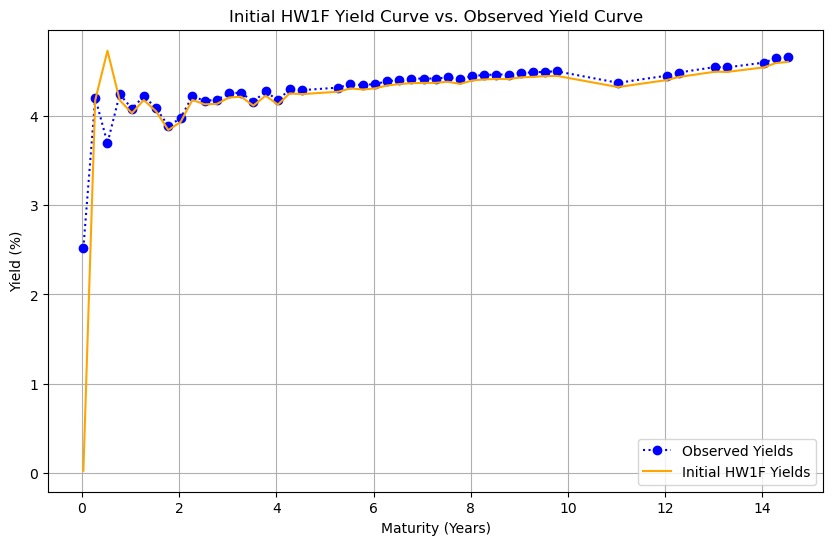

In [120]:
#Plot Initial Fit
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields * 100, marker='o', linestyle='dotted', label='Observed Yields', color='blue')
plt.plot(maturities, test_yields, linestyle='solid', label='Initial HW1F Yields', color='orange')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('Initial HW1F Yield Curve vs. Observed Yield Curve')
plt.legend()
plt.grid(True)
plt.show()

In [111]:
from scipy.optimize import minimize

In [121]:
# Fitter Function with Calibration
class ModelFitter:
    def __init__(self, model, maturities, observed_yields, all_maturities):
        self.model = model
        self.maturities = maturities
        self.observed_yields = observed_yields
        self.all_maturities = all_maturities
        # Weighting to reduce influence of short maturities
        self.weights = np.ones_like(maturities)
        self.weights[maturities < 0.1] = 0.1  # Downweight maturities < 0.1 years
    
    def yield_error(self, params):
        self.model.update_params(params)
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        errors = (model_yields - self.observed_yields) ** 2
        weighted_errors = np.sum(errors * self.weights)
        reg_term = 0.01 * (params[0]**2 + params[1]**2)  # Regularization on a and sigma
        return weighted_errors + reg_term
    
    def calibrate(self):
        initial_params = [self.model.a, self.model.sigma, self.model.r0]
        print("Initial Parameters [a, sigma, r0]:", initial_params)
        bounds = [(1e-6, 2.0), (1e-6, 0.2), (1e-6, 0.2)]  # Relaxed bounds
        result = minimize(
            self.yield_error,
            initial_params,
            method='Nelder-Mead',
            bounds=bounds,
            options={'disp': True, 'maxiter': 2000}
        )
        if result.success:
            self.model.update_params(result.x)
            print("Calibration Successful. Optimized Parameters [a, sigma, r0]:", result.x)
        else:
            print("Calibration Failed:", result.message)
        return result.success
    
    def r_squared(self):
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        mean_yield = np.mean(self.observed_yields)
        ss_tot = np.sum((self.observed_yields - mean_yield) ** 2)
        ss_res = np.sum((self.observed_yields - model_yields) ** 2)
        return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    
    def rmse(self):
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        return np.sqrt(np.mean((self.observed_yields - model_yields) ** 2))
    
    def aic(self):
        n = len(self.maturities)
        k = 3  # Number of parameters: a, sigma, r0
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        rss = np.sum((self.observed_yields - model_yields) ** 2)
        if rss <= 0:
            rss = 1e-10  # Avoid log(0)
        return n * np.log(rss / n) + 2 * k

# Calibrate the model using all maturities
fitter = ModelFitter(hw1f, maturities, yields * 100, maturities)
fitter.calibrate()

Initial Parameters [a, sigma, r0]: [0.1, 0.01, 0.000252]
Optimization terminated successfully.
         Current function value: 1.175361
         Iterations: 42
         Function evaluations: 83
Calibration Successful. Optimized Parameters [a, sigma, r0]: [1.00000000e-06 1.00000000e-06 2.52316149e-02]


True

In [122]:
# Compute and print metrics
r2 = fitter.r_squared()
rmse = fitter.rmse()
aic = fitter.aic()
print(f"R-squared: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"AIC: {aic:.1f}")

# Save metrics
metrics = {'R-squared': r2, 'RMSE': rmse, 'AIC': aic}
pd.DataFrame([metrics]).to_csv('hull_white_one_factor_metrics.csv', index=False)

R-squared: 0.758
RMSE: 0.160
AIC: -162.7


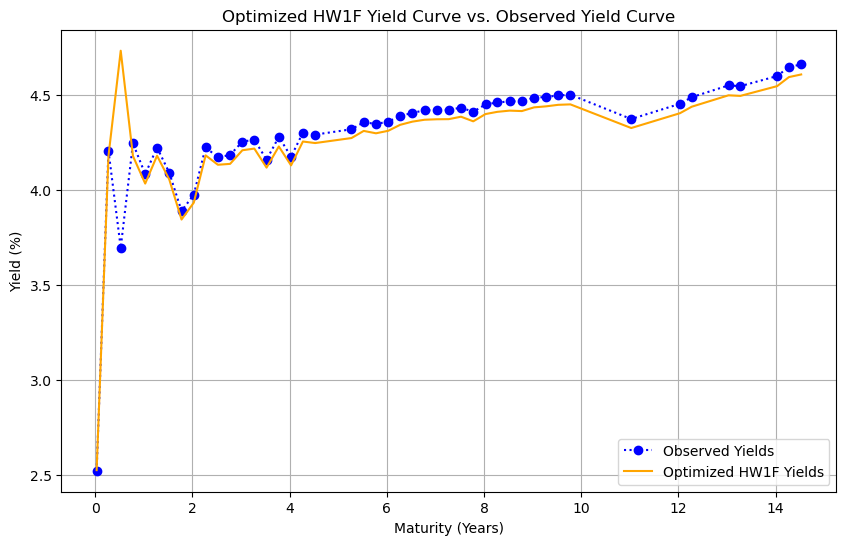

In [123]:
# Plot Optimized Model Curve vs. Yield Curve
optimized_yields = np.array([hw1f.yield_curve(tau) for tau in maturities])
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields * 100, marker='o', linestyle='dotted', label='Observed Yields', color='blue')
plt.plot(maturities, optimized_yields, linestyle='solid', label='Optimized HW1F Yields', color='orange')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('Optimized HW1F Yield Curve vs. Observed Yield Curve')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
# Collinearity Check
# jac = fit_results.jac
# c = np.cov(np.transpose(jac))
# val, vec = np.linalg.eig(c)
# cn = val[0] / val[-1]
# print("Condition number:", cn)

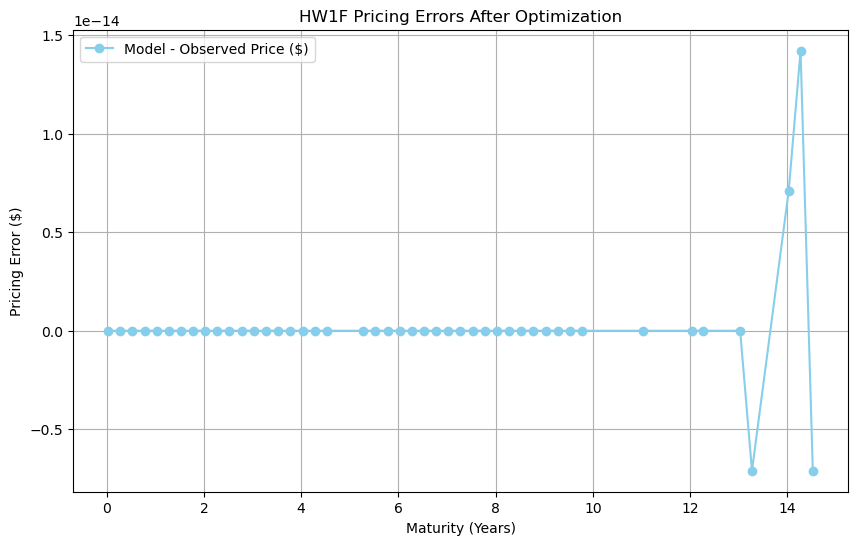

In [125]:
# Plot Pricing Errors
optimized_prices = np.array([hw1f.zero(0, tau) * face_value for tau in maturities])
price_differences = optimized_prices - prices
plt.figure(figsize=(10, 6))
plt.plot(maturities, price_differences, 'o-', color='skyblue', label='Model - Observed Price ($)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Pricing Error ($)')
plt.title('HW1F Pricing Errors After Optimization')
plt.legend()
plt.grid(True)
plt.show()

# Two-Factor Hull-White Model

In [126]:
# Model Class (Hull-White Two-Factor)
class Two_Factor_Model:
    def __init__(self, maturities, a1, a2, sigma1, sigma2, rho, x1_0, x2_0):
        self.maturities = np.array(maturities)
        self.a1 = a1
        self.a2 = a2
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.rho = rho
        self.x1_0 = x1_0
        self.x2_0 = x2_0
        self.log_price_func = log_price_func  # Interpolated log prices from data
    
    def B(self, t, T, a):
        """Compute B(t,T) for a given mean-reversion speed a."""
        if a <= 0:
            return T - t  # Handle edge case for a -> 0
        return (1 - np.exp(-a * (T - t))) / a
    
    def A(self, t, T):
        """Compute A(t,T) to match the initial term structure exactly."""
        B1 = self.B(t, T, self.a1)
        B2 = self.B(t, T, self.a2)
        ln_P = self.log_price_func(T)
        
        # Volatility terms
        if self.a1 <= 0 or self.a2 <= 0:
            vol_term = 0  # Avoid division by zero
        else:
            # Term 1: sigma1^2 contribution
            term1 = (self.sigma1**2 / (2 * self.a1**2)) * (
                (T - t) +
                (2 / self.a1) * np.exp(-self.a1 * (T - t)) -
                (1 / (2 * self.a1)) * np.exp(-2 * self.a1 * (T - t)) -
                (3 / (2 * self.a1))
            )
            # Term 2: sigma2^2 contribution
            term2 = (self.sigma2**2 / (2 * self.a2**2)) * (
                (T - t) +
                (2 / self.a2) * np.exp(-self.a2 * (T - t)) -
                (1 / (2 * self.a2)) * np.exp(-2 * self.a2 * (T - t)) -
                (3 / (2 * self.a2))
            )
            # Term 3: Correlation term (rho * sigma1 * sigma2)
            term3 = (self.rho * self.sigma1 * self.sigma2 / (self.a1 * self.a2)) * (
                (T - t) +
                (np.exp(-self.a1 * (T - t)) - 1) / self.a1 +
                (np.exp(-self.a2 * (T - t)) - 1) / self.a2 -
                (np.exp(-(self.a1 + self.a2) * (T - t)) - 1) / (self.a1 + self.a2)
            )
            vol_term = term1 + term2 + term3
        
        return ln_P + B1 * self.x1_0 + B2 * self.x2_0 + vol_term
    
    def zero(self, t, T):
        """Compute zero-coupon bond price P(t,T)."""
        if T <= t:
            return 1.0
        B1 = self.B(t, T, self.a1)
        B2 = self.B(t, T, self.a2)
        A = self.A(t, T)
        return np.exp(A - B1 * self.x1_0 - B2 * self.x2_0)
    
    def yield_curve(self, tau):
        """Compute yield for maturity tau in percentage."""
        if tau <= 0:
            return np.nan
        p = self.zero(0, tau)
        # For very small tau, approximate yield with r(0) = x1_0 + x2_0
        if tau < 0.05:
            return (self.x1_0 + self.x2_0) * 100
        return -np.log(p) / tau * 100
    
    def update_params(self, params):
        """Update model parameters."""
        self.a1, self.a2, self.sigma1, self.sigma2, self.rho, self.x1_0, self.x2_0 = params
        self.a1 = max(self.a1, 1e-6)
        self.a2 = max(self.a2, 1e-6)
        self.sigma1 = max(self.sigma1, 1e-6)
        self.sigma2 = max(self.sigma2, 1e-6)
        self.rho = max(min(self.rho, 1.0), -1.0)  # Ensure rho in [-1, 1]
        self.x1_0 = max(self.x1_0, 1e-6)
        self.x2_0 = max(self.x2_0, 1e-6)

In [127]:
# Test the Model
# Initial parameters: a1, a2 (mean-reversion speeds), sigma1, sigma2 (volatilities), rho (correlation), x1_0, x2_0
initial_r0 = yields[0] / 100  # Use the shortest maturity yield (~5%)
initial_params = [0.1, 0.05, 0.01, 0.005, 0.0, initial_r0 / 2, initial_r0 / 2]  # Split r0 between x1_0 and x2_0
hw2f = Two_Factor_Model(maturities, *initial_params)

# Test bond prices and yields
test_prices = np.array([hw2f.zero(0, tau) * face_value for tau in maturities])
test_yields = np.array([hw2f.yield_curve(tau) for tau in maturities])
print("Initial Model Prices:", test_prices)
print("Initial Model Yields:", test_yields)

Initial Model Prices: [99.93200006 98.8630415  97.54428495 96.80589998 95.93703551 94.82374473
 94.01327654 93.41070401 92.34904745 90.95813994 90.12457746 89.18813082
 88.08178163 87.15846865 86.5548297  85.31597421 84.76598953 83.48394564
 82.64213151 80.00923904 79.01190437 78.2402709  77.36248805 76.43068435
 75.54490972 74.69928155 73.89982874 73.13679562 72.29998226 71.67626977
 70.71231741 69.9269708  69.1556334  68.44445625 67.60887503 66.89050128
 66.13869681 65.43082878 62.9732841  59.93812284 59.10009759 56.86488712
 56.32095247 54.21450331 53.30745024 52.64486172]
Initial Model Yields: [0.0252     4.17652888 4.72993167 4.17494169 4.02922135 4.17487318
 4.04818798 3.83620799 3.92334662 4.17048549 4.11905652 4.12156953
 4.19094542 4.19738965 4.09465961 4.20324613 4.10101783 4.22379313
 4.21265095 4.22954323 4.2637536  4.2477311  4.25740465 4.28520583
 4.29843728 4.30478059 4.30359939 4.30050032 4.3094757  4.28131186
 4.3156337  4.32352012 4.32588617 4.31951562 4.33505594 4.33

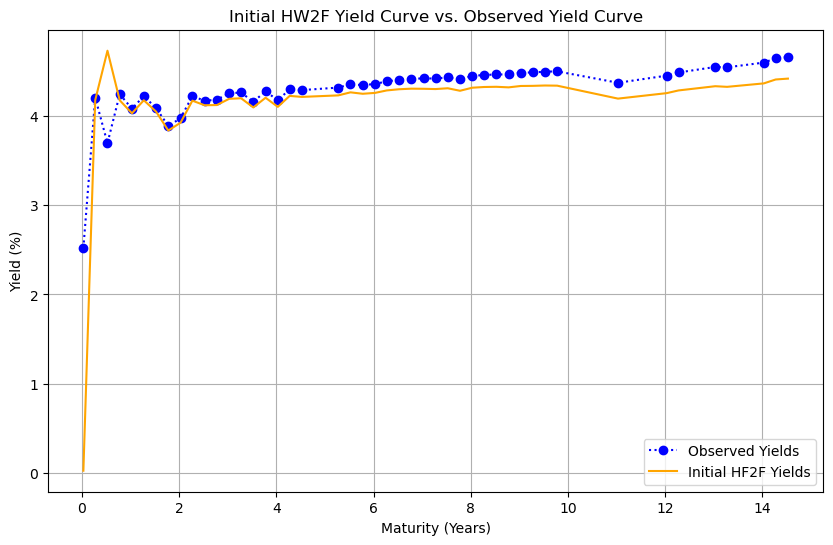

In [128]:
# Plot Initial Model Curve vs. Yield Curve
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields * 100, marker='o', linestyle='dotted', label='Observed Yields', color='blue')
plt.plot(maturities, test_yields, linestyle='solid', label='Initial HF2F Yields', color='orange')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('Initial HW2F Yield Curve vs. Observed Yield Curve')
plt.legend()
plt.grid(True)
plt.show()

In [129]:

# Fitter Function with Calibration
class ModelFitter:
    def __init__(self, model, maturities, observed_yields, all_maturities):
        self.model = model
        self.maturities = maturities
        self.observed_yields = observed_yields
        self.all_maturities = all_maturities
        # Weighting to reduce influence of short maturities
        self.weights = np.ones_like(maturities)
        self.weights[maturities < 0.1] = 0.1  # Downweight maturities < 0.1 years
    
    def yield_error(self, params):
        self.model.update_params(params)
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        errors = (model_yields - self.observed_yields) ** 2
        weighted_errors = np.sum(errors * self.weights)
        # Regularization on a1, a2, sigma1, sigma2
        reg_term = 0.01 * (params[0]**2 + params[1]**2 + params[2]**2 + params[3]**2)
        return weighted_errors + reg_term
    
    def calibrate(self):
        initial_params = [self.model.a1, self.model.a2, self.model.sigma1, self.model.sigma2, self.model.rho, self.model.x1_0, self.model.x2_0]
        print("Initial Parameters [a1, a2, sigma1, sigma2, rho, x1_0, x2_0]:", initial_params)
        bounds = [(1e-6, 2.0), (1e-6, 2.0), (1e-6, 0.2), (1e-6, 0.2), (-1.0, 1.0), (1e-6, 0.2), (1e-6, 0.2)]
        result = minimize(
            self.yield_error,
            initial_params,
            method='Nelder-Mead',
            bounds=bounds,
            options={'disp': True, 'maxiter': 2000}
        )
        if result.success:
            self.model.update_params(result.x)
            print("Calibration Successful. Optimized Parameters [a1, a2, sigma1, sigma2, rho, x1_0, x2_0]:", result.x)
        else:
            print("Calibration Failed:", result.message)
        return result.success
    
    def r_squared(self):
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        mean_yield = np.mean(self.observed_yields)
        ss_tot = np.sum((self.observed_yields - mean_yield) ** 2)
        ss_res = np.sum((self.observed_yields - model_yields) ** 2)
        return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    
    def rmse(self):
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        return np.sqrt(np.mean((self.observed_yields - model_yields) ** 2))
    
    def aic(self):
        n = len(self.maturities)
        k = 7  # Number of parameters: a1, a2, sigma1, sigma2, rho, x1_0, x2_0
        model_yields = np.array([self.model.yield_curve(tau) for tau in self.maturities])
        rss = np.sum((self.observed_yields - model_yields) ** 2)
        if rss <= 0:
            rss = 1e-10  # Avoid log(0)
        return n * np.log(rss / n) + 2 * k

# Calibrate the model using all maturities
fitter = ModelFitter(hw2f, maturities, yields * 100, maturities)
fitter.calibrate()

Initial Parameters [a1, a2, sigma1, sigma2, rho, x1_0, x2_0]: [0.1, 0.05, 0.01, 0.005, 0.0, 0.000126, 0.000126]
Optimization terminated successfully.
         Current function value: 1.175361
         Iterations: 232
         Function evaluations: 366
Calibration Successful. Optimized Parameters [a1, a2, sigma1, sigma2, rho, x1_0, x2_0]: [ 5.66198836e-04  1.00000000e-06  1.00000000e-06  1.00000000e-06
 -4.64180393e-01  1.33212807e-02  1.18788346e-02]


True

In [130]:
# Compute and print metrics
r2 = fitter.r_squared()
rmse = fitter.rmse()
aic = fitter.aic()
print(f"R-squared: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"AIC: {aic:.1f}")

# Save metrics
metrics = {'R-squared': r2, 'RMSE': rmse, 'AIC': aic}
pd.DataFrame([metrics]).to_csv('hull_white_two_factor_metrics.csv', index=False)

R-squared: 0.758
RMSE: 0.160
AIC: -154.7


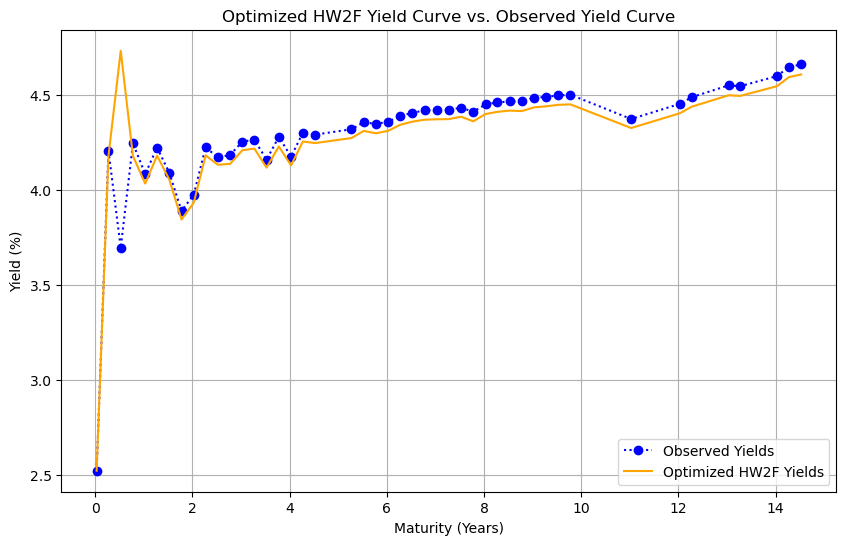

In [132]:
# Plot Optimized Model Curve vs. Yield Curve
optimized_yields = np.array([hw2f.yield_curve(tau) for tau in maturities])
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields * 100, 'o', linestyle='dotted', label='Observed Yields', color='blue')
plt.plot(maturities, optimized_yields, linestyle='solid', label='Optimized HW2F Yields', color='orange')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('Optimized HW2F Yield Curve vs. Observed Yield Curve')
plt.legend()
plt.grid(True)
plt.show()

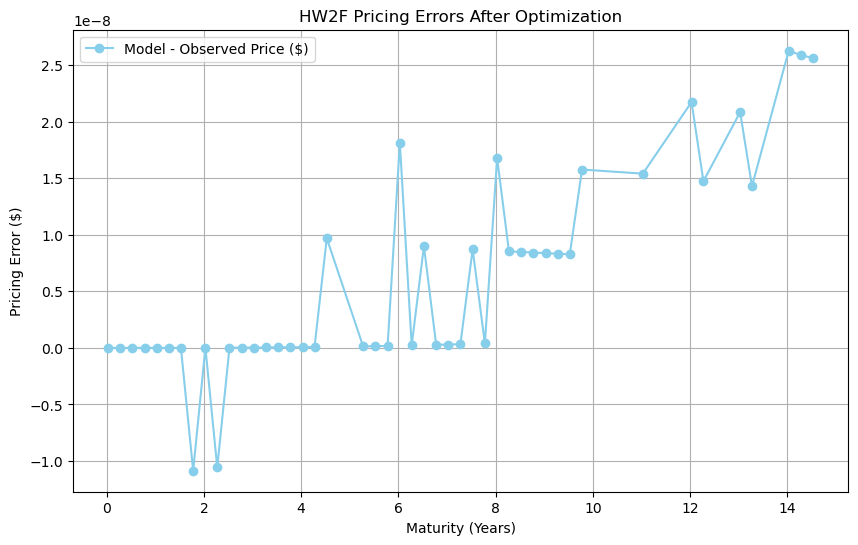

In [ ]:
# Plot Pricing Errors
optimized_prices = np.array([hw2f.zero(0, tau) * face_value for tau in maturities])
price_differences = optimized_prices - prices
plt.figure(figsize=(10, 6))
plt.plot(maturities, price_differences, 'o-', color='skyblue', label='Model - Observed Price ($)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Pricing Error ($)')
plt.title('HW2F Pricing Errors After Optimization')
plt.legend()
plt.grid(True)
plt.show()